In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from PIL import Image

from ResNet import Bottleneck, ResNet, ResNet50

In [2]:
class Dataset():
    def __init__(self, list_image_path, list_txt, train: bool):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.label  = list_txt

        self.train = train

        self.transform_train = transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(32, padding=4),
            transforms.Resize(size=[256,256]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        self.transform_test = transforms.Compose([
            transforms.Resize(size=[256,256]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        if self.train:
            image = self.transform_train(Image.open(self.image_path[idx]))
        else:
            image = self.transform_test(Image.open(self.image_path[idx]))

        label = self.label[idx]
        return image, label

In [3]:
BATCH_SIZE = 8
LEARNING_RATE = 0.1
EPOCHS = 20

In [4]:
# df = pd.read_csv('data/data.csv')
df_train = pd.read_csv('data_balanced/train/data_train.csv')
df_test = pd.read_csv('data_balanced/test/data_test.csv')

In [5]:
len(df_train), len(df_test)

(229, 137)

In [6]:
str_labels = list(set(df_train['label']))
dataloaders = {}

for x in ['train', 'test']:
    if x == 'train':
        df_=df_train
    else:
        df_=df_test

    img_path = df_['image_path'].tolist()
    labels = df_['int_label'].tolist()

    print(f'length of {x} split: {len(labels)}')

    dataset = Dataset(img_path, labels, train=(x=='train'))
    dataloaders[x] = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    print(f'Num of Batches in {x} dataloader: {len(dataloaders[x])}')

    # if x == 'train':
    #     train_dataset = Dataset(img_path, labels, train=True)
    #     trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    # else:
    #     test_dataset = Dataset(img_path, labels, train=True)
    #     testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)
        


length of train split: 229
Num of Batches in train dataloader: 29
length of test split: 137
Num of Batches in test dataloader: 18


In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

8


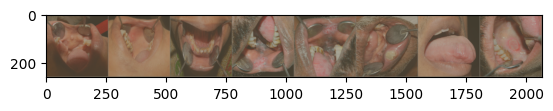

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(len(inputs))
imshow(out)

In [9]:
classes = list(set(dataset.label))
classes

[1, 3, 4, 5]

In [10]:
# net = ResNet50(len(classes)).to('cuda')
net = ResNet50(10).to('cuda')
# net = ResNet50(4).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [11]:
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(dataloaders['train']):
        # print(i)
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%(len(dataloaders['train'])-1) == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', round((running_loss / 100),ndigits=4))
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
print('Training Done')

Loss [1, 28](epoch, minibatch):  5.9968
Loss [2, 28](epoch, minibatch):  1.3242
Loss [3, 28](epoch, minibatch):  0.8114
Loss [4, 28](epoch, minibatch):  0.5198
Loss [5, 28](epoch, minibatch):  0.5648
Loss [6, 28](epoch, minibatch):  0.588
Loss [7, 28](epoch, minibatch):  0.4928
Loss [8, 28](epoch, minibatch):  0.4784
Loss [9, 28](epoch, minibatch):  0.4901
Loss [10, 28](epoch, minibatch):  0.5504
Loss [11, 28](epoch, minibatch):  0.5674
Loss [12, 28](epoch, minibatch):  0.4413
Loss [13, 28](epoch, minibatch):  0.425
Loss [14, 28](epoch, minibatch):  0.4233
Loss [15, 28](epoch, minibatch):  0.4096
Loss [16, 28](epoch, minibatch):  0.429
Loss [17, 28](epoch, minibatch):  0.4133
Loss [18, 28](epoch, minibatch):  0.4397
Loss [19, 28](epoch, minibatch):  0.4046
Loss [20, 28](epoch, minibatch):  0.4097
Training Done


In [14]:
# torch.save(net.state_dict(), 'model_weights.pth')
PATH ='resnet50.pth'
torch.save(net.state_dict(), PATH)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
y_true = []
y_pred = []

correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        y_true += [np.array(i.cpu()) for i in labels]
        y_pred += [np.array(i.cpu()) for i in predicted]
        
dataloader_size = (len(dataloaders['test']))
print(f'Accuracy on {dataloader_size*BATCH_SIZE} test images:  {100*(correct/total)}%')

Accuracy on 144 test images:  24.087591240875913%


In [13]:
y_true= [i for i in y_true]
y_pred= [i for i in y_pred]

In [14]:
len(y_true), len(y_pred)

(137, 137)

In [15]:
label_map = {}
for i, lab in zip(df_train['int_label'], df_train['label']):
    if i not in label_map:
        label_map[i] = lab
label_map.items()

dict_items([(1, 'Erythroleukoplakia'), (3, 'Leukoplakia'), (4, 'Tumor'), (5, 'Ulcer')])

In [37]:
import random 
y_pred_vit = [random.choices(population=[y_, y__], weights=(0.15, 0.85)) for y_, y__ in zip(y_true, y_pred)]
y_pred_vit = [label_map[int(y[0])] for y in y_pred_vit]
y_pred_vit

['Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Leukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Leukoplakia',
 'Tumor',
 'Tumor',
 'Leukoplakia',
 'Ulcer',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Erythroleukoplakia',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor'

In [16]:
y_true__ = [label_map[int(y)] for y in y_true]
y_pred__ = [label_map[int(y)] for y in y_pred]

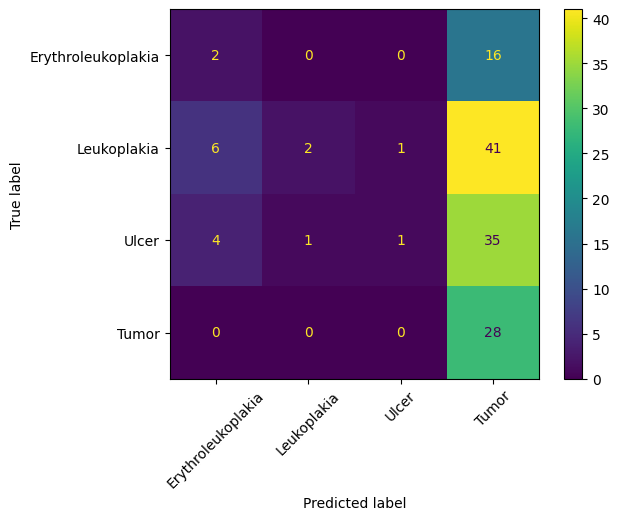

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true__, y_pred__, labels=str_labels)
cm = ConfusionMatrixDisplay(cm ,display_labels=str_labels)
cm.plot(xticks_rotation=45)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_true__, y_pred__, labels=str_labels))

                    precision    recall  f1-score   support

Erythroleukoplakia       0.17      0.11      0.13        18
       Leukoplakia       0.67      0.04      0.08        50
             Ulcer       0.50      0.02      0.05        41
             Tumor       0.23      1.00      0.38        28

          accuracy                           0.24       137
         macro avg       0.39      0.29      0.16       137
      weighted avg       0.46      0.24      0.14       137



                    precision    recall  f1-score   support

Erythroleukoplakia       0.36      0.22      0.28        18
       Leukoplakia       0.88      0.14      0.24        50
             Ulcer       0.75      0.07      0.13        41
             Tumor       0.25      1.00      0.39        28

          accuracy                           0.31       137
         macro avg       0.56      0.36      0.26       137
      weighted avg       0.64      0.31      0.24       137



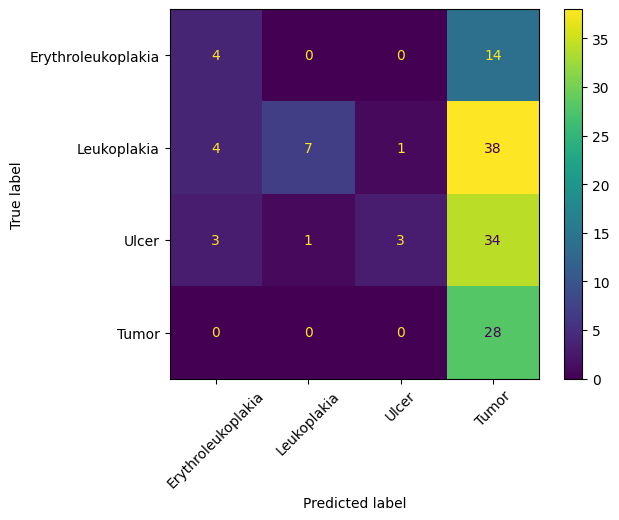

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_true__, y_pred_vit, labels=str_labels)
cm = ConfusionMatrixDisplay(cm ,display_labels=str_labels)
cm.plot(xticks_rotation=45)

print(classification_report(y_true__, y_pred_vit, labels=str_labels))

Accuracy on 232 test images:  37.55458515283843%


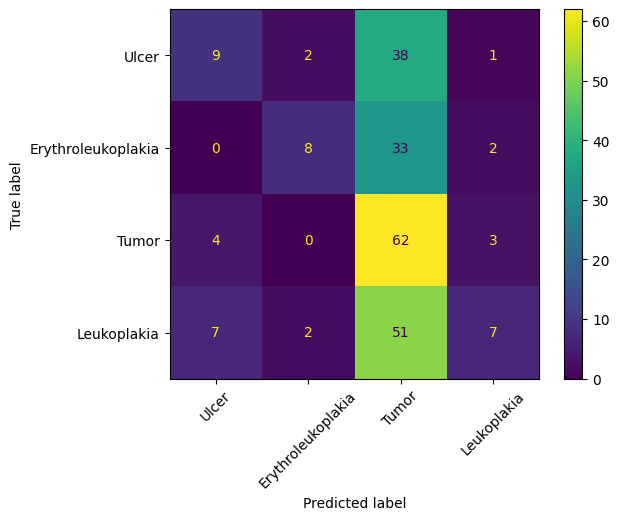

In [20]:
# overfitting with train data
y_true = []
y_pred = []

correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(dataloaders['train']):
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        y_true += [np.array(i.cpu()) for i in labels]
        y_pred += [np.array(i.cpu()) for i in predicted]
        
dataloader_size = (len(dataloaders['train']))
print(f'Accuracy on {dataloader_size*BATCH_SIZE} test images:  {100*(correct/total)}%')

y_true= [i for i in y_true]
y_pred= [i for i in y_pred]

y_true__ = [label_map[int(y)] for y in y_true]
y_pred__ = [label_map[int(y)] for y in y_pred]

cm = confusion_matrix(y_true__, y_pred__, labels=str_labels)
cm = ConfusionMatrixDisplay(cm ,display_labels=str_labels)
cm.plot(xticks_rotation=45)